# Data load : set your target and unsused_features 


In [1]:
from torch import nn
import torch
from torch import tensor 
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from sklearn.metrics import roc_auc_score

test_data = pd.read_csv('./data/test.mor.con.csv')
train_data = pd.read_csv('./data/train.mor.con.csv')

target='sex'
unused_feat = ['Set', 'subjectkey', 'race.ethnicity', 'abcd_site', 'Unnamed: 0']


# train data and valida data would be 75% and 25% of train data.

In [2]:
# na 에 0을 채우고 index reset

test_data_processed= test_data.fillna(0).reset_index(drop=True)
train_data_processed = train_data.fillna(0).reset_index(drop=True)


features = [ col for col in train_data_processed.columns if col not in unused_feat + [target]] 

if "Set" not in train_data_processed.columns:
    train_data_processed["Set"] = np.random.choice(["train", "valid"] , p =[.75, .25], size=(train_data_processed.shape[0],))

train_indices = train_data_processed[train_data_processed.Set=="train"].index
valid_indices = train_data_processed[train_data_processed.Set=="valid"].index



# Split data 

In [3]:

X_train = train_data_processed[features].values[train_indices]
y_train = train_data_processed[target].values[train_indices]
X_valid = train_data_processed[features].values[valid_indices]
y_valid = train_data_processed[target].values[valid_indices]
X_test = test_data_processed[features].values
y_test = test_data_processed[target].values

print("X_train.shape: ", X_train.shape)
print("y_train.shape: ",y_train.shape)
print("X_valid.shape: ", X_valid.shape)
print("y_valid.shape: ",y_valid.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ",y_test.shape)

X_train.shape:  (5770, 4530)
y_train.shape:  (5770,)
X_valid.shape:  (2054, 4530)
y_valid.shape:  (2054,)
X_test.shape:  (1957, 4530)
y_test.shape:  (1957,)


# Hyperparameter tuning

In [4]:
# Augmented
import torch
import itertools
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm.notebook import tqdm
# Store maximum auc
max_auc = 0
# Store maximum hypterparameter set
max_hy = []
# define hyperparameter space
n_ = [4,8,16]
lr_ = [2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 1e-4]
w_ = [0.01, 0.001, 0.0001]
g_ = [0.95, 0.99, 0.9]
ss_ = [10, 20, 30]
all_ = [n_, lr_, w_, g_, ss_]
h_space = [s for s in itertools.product(*all_)]
# Start training


for hy in tqdm(h_space):
    clf = TabNetClassifier(n_a = hy[0],
                           n_d = hy[0],
                           optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                           scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                           scheduler_fn=torch.optim.lr_scheduler.StepLR,
                           verbose=0
                           )
    clf.fit(X_train, y_train, X_valid, y_valid, patience=50, batch_size=256, max_epochs=200)
    preds_acc = clf.predict(X_test)
    preds_prob = clf.predict_proba(X_test)
    test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=y_test)
    test_acc = accuracy_score(preds_acc, y_test)
    print("FINAL TEST SCORE", test_auc, test_acc)
    if test_auc>max_auc:
        max_hy = hy
        max_auc = test_auc


Device used : cuda
FINAL TEST SCORE 0.9312789421418491 0.8482370975983649
Device used : cuda
FINAL TEST SCORE 0.9254690848272618 0.8497700562084823
Device used : cuda
FINAL TEST SCORE 0.9291329117232007 0.8196218702095044
Device used : cuda
FINAL TEST SCORE 0.9263325145037371 0.8308635666836995
Device used : cuda
FINAL TEST SCORE 0.9333444833533685 0.8599897802759325
Device used : cuda
FINAL TEST SCORE 0.9291329117232007 0.8196218702095044
Device used : cuda
FINAL TEST SCORE 0.9314503736998903 0.832396525293817
Device used : cuda
FINAL TEST SCORE 0.9291329117232007 0.8196218702095044
Device used : cuda
FINAL TEST SCORE 0.9237317723305284 0.8472151251916198
Device used : cuda
FINAL TEST SCORE 0.9273548319657137 0.85947879407256
Device used : cuda
FINAL TEST SCORE 0.9246234254952177 0.8548799182422074
Device used : cuda
FINAL TEST SCORE 0.9273579679088487 0.85334695963209
Device used : cuda
FINAL TEST SCORE 0.9278586734960539 0.8589678078691876
Device used : cuda
FINAL TEST SCORE 0.92053

KeyboardInterrupt: 

# Do it with best hyperparameter 

In [5]:
hy = max_hy
clf = TabNetClassifier(n_a = hy[0],
                       n_d = hy[0],
                       optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                       scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       verbose=0
                           )
clf.fit(X_train, y_train, X_valid, y_valid, patience=50, batch_size=256, max_epochs=200)
preds_acc = clf.predict(X_test)
preds_prob = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=y_test)
test_acc = accuracy_score(preds_acc, y_test)
print("Best hy:", hy)
print("FINAL TEST SCORE", test_auc, test_acc)

Device used : cuda
Best hy: (4, 0.02, 0.01, 0.99, 20)
FINAL TEST SCORE 0.9333444833533685 0.8599897802759325


## Global explainability : feat importance summing to 1

,feature name,ratio
0,con_L.CU_R.CU_count,0.168218
1,con_L.ITG_R.LOFG_count,0.137826
2,con_R.LOG_R.LG_count,0.118547
3,lh_G_cingul.Post.ventral_meancurv._.11,0.085666
4,lh_frontalpole_area._.1,0.060923


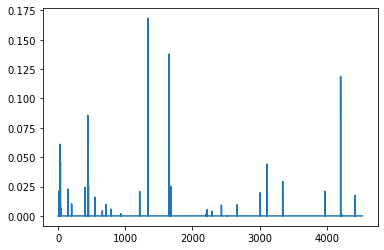

In [8]:
importance =clf.feature_importances_
plt.plot(importance)

labels_importance=importance.argsort()[::-1]

importance_sort = np.sort(importance)[::-1]

feat_name_sort=test_data_processed[features].columns[labels_importance]
important_features = pd.DataFrame() 


for i in range (5):
    feature = pd.DataFrame([[feat_name_sort[i],importance_sort[i]]], columns = ['feature name', 'ratio'])
    important_features=pd.concat([important_features,feature])

important_features.reset_index(drop=True)

## Local explainability and masks

In [70]:
explain_matrix, masks = clf.explain(X_test)
epochs = 0
#fig, axs = plt.subplots(1, 3, figsize=(20,20))
for raw in range(explain_matrix.shape[0]):
    epochs += 1
    importance = explain_matrix[raw]
    labels_importance=importance.argsort()[::-1]
    
    importance_sort = np.sort(importance)[::-1]

    feat_name_sort=test_data_processed[features].columns[labels_importance]
    important_features = pd.DataFrame() 


    for i in range (5):
        feature = pd.DataFrame([[feat_name_sort[i],importance_sort[i]]], columns = ['feature name', 'ratio'])
        important_features=pd.concat([important_features,feature])
    
    print ("--------Subjectkey: {} -----------------".format(test_data_processed['subjectkey'][raw]))
    print ("         total percentage: {}% ".format(round(100*epochs/explain_matrix.shape[0]),2))
    print ("                                             ")
    print (important_features.reset_index(drop=True))
    print ("                                             ")
    print ("----------------------------------------------------")
    print ("                                             ")



--------Subjectkey: NDAR_INV007W6H7B -----------------
         total percentage: 0% 
                                             
                             feature name     ratio
0                    con_R.LOG_R.LG_count  0.695457
1                  con_L.ITG_R.LOFG_count  0.334946
2                  BrainSegVolNotVent._.1  0.134406
3                 lh_frontalpole_area._.1  0.080931
4  lh_G_cingul.Post.ventral_meancurv._.11  0.068136
                                             
----------------------------------------------------
                                             
--------Subjectkey: NDAR_INV00LH735Y -----------------
         total percentage: 0% 
                                             
                             feature name     ratio
0                  con_L.ITG_R.LOFG_count  0.201732
1                     con_L.CU_R.CU_count  0.198541
2  lh_G_cingul.Post.ventral_meancurv._.11  0.126886
3                    con_R.LOG_R.LG_count  0.121382
4                 l

## Save and load Model

In [72]:
# save tabnet model
saving_path_name = "./sexclassification_tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./sexclassification_tabnet_model_test_1.zip


In [81]:

# define new model with basic parameters and load state dict weights
loaded_clf = TabNetRegressor()
loaded_clf.load_model(saved_filepath)

loaded_clf

Device used : cuda
Device used : cuda


TabNetRegressor(cat_dims=[], cat_emb_dim=1, cat_idxs=[], clip_value=1,
                device_name='auto', epsilon=1e-15, gamma=1.3, input_dim=4530,
                lambda_sparse=0.001, mask_type='sparsemax', momentum=0.02,
                n_a=4, n_d=4, n_independent=2, n_shared=2, n_steps=3,
                optimizer_fn=<class 'torch.optim.adam.Adam'>,
                optimizer_params={'lr': 0.02, 'weight_decay': 0.01},
                output_dim=2, scheduler_fn=None,
                scheduler_params={'gamma': 0.99, 'step_size': 20}, seed=0,
                verbose=0)

In [76]:

loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR : {loaded_test_auc}")

FINAL TEST SCORE FOR : 0.9333439606961793
